# Seattle Paramedic Deployment Optimization

## Import libraries

In [1]:
# Install the pydotplus library
!conda install -c conda-forge pydotplus -y

Solving environment: done

# All requested packages already installed.



In [2]:
# Import libraries
import pandas as pd
import numpy as np
#
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
#
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
#
from sklearn.tree import DecisionTreeClassifier
from six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
#
from sklearn.neighbors import KNeighborsClassifier
#
from sklearn.linear_model import LogisticRegression

## Read data and basic details

# Read the data

In [3]:
df = pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv')

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Get familiar with the dataset

In [4]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [5]:
df.shape

(194673, 38)

In [6]:
df.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

## Have a look at the target variable (lopsided)

In [7]:
df['SEVERITYDESC'].value_counts()

Property Damage Only Collision    136485
Injury Collision                   58188
Name: SEVERITYDESC, dtype: int64

## The dataset is robust in time with several years of data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17b197a208>]],
      dtype=object)

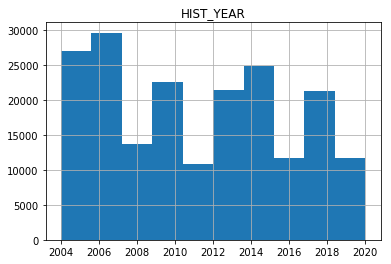

In [8]:
df['HIST_DATE'] = pd.to_datetime(df.INCDATE,format="%Y/%m/%dT%H:%M:%S")
df['HIST_YEAR'] = df['HIST_DATE'].dt.year
df.hist('HIST_YEAR')

## Process NULLs for categorical variables
### Replace NULLs with most common value

In [9]:
NaN_df = df[['ADDRTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SEVERITYCODE', 
             'SEVERITYDESC', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'PERSONCOUNT',  
             'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'SDOT_COLDESC',
             'UNDERINFL']]

* ADDRTYPE

In [10]:
NaN_df['ADDRTYPE'].value_counts()

Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64

In [11]:
NaN_df['ADDRTYPE'].isnull().sum()

1926

In [12]:
NaN_df['ADDRTYPE'].value_counts().idxmax()

'Block'

In [13]:
NaN_df['ADDRTYPE'].replace(np.nan, 'Block', inplace=True)
NaN_df['ADDRTYPE'].value_counts()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Block           128852
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64

* WEATHER

In [14]:
NaN_df['WEATHER'].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [15]:
NaN_df['WEATHER'].isnull().sum()

5081

In [16]:
NaN_df['WEATHER'].value_counts().idxmax()

'Clear'

In [17]:
NaN_df['WEATHER'].replace(np.nan, 'Clear', inplace=True)
NaN_df['WEATHER'].value_counts()

Clear                       116216
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

* ROADCOND

In [18]:
NaN_df['ROADCOND'].value_counts()

Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

In [19]:
NaN_df['ROADCOND'].isnull().sum()

5012

In [20]:
NaN_df['ROADCOND'].value_counts().idxmax()

'Dry'

In [21]:
NaN_df['ROADCOND'].replace(np.nan, 'Dry', inplace=True)
NaN_df['ROADCOND'].value_counts()

Dry               129522
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

* LIGHTCOND

In [22]:
NaN_df['LIGHTCOND'].value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [23]:
NaN_df['LIGHTCOND'].isnull().sum()

5170

In [24]:
NaN_df['LIGHTCOND'].value_counts().idxmax()

'Daylight'

In [25]:
NaN_df['LIGHTCOND'].replace(np.nan, 'Daylight', inplace=True)
NaN_df['LIGHTCOND'].value_counts()

Daylight                    121307
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

* COLLISIONTYPE

In [26]:
NaN_df['COLLISIONTYPE'].value_counts()

Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64

In [27]:
NaN_df['COLLISIONTYPE'].isnull().sum()

4904

In [28]:
NaN_df['COLLISIONTYPE'].value_counts().idxmax()

'Parked Car'

In [29]:
NaN_df['COLLISIONTYPE'].replace(np.nan, 'Parked Car', inplace=True)
NaN_df['COLLISIONTYPE'].value_counts()

Parked Car    52891
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64

* JUNCTIONTYPE

In [30]:
NaN_df['JUNCTIONTYPE'].value_counts()

Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64

In [31]:
NaN_df['JUNCTIONTYPE'].isnull().sum()

6329

In [32]:
NaN_df['JUNCTIONTYPE'].value_counts().idxmax()

'Mid-Block (not related to intersection)'

In [33]:
NaN_df['JUNCTIONTYPE'].replace(np.nan, 'Mid-Block (not related to intersection)', inplace=True)
NaN_df['JUNCTIONTYPE'].value_counts()

Mid-Block (not related to intersection)              96129
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64

* UNDERINFL (has 0/1 & N/Y to be fixed first)

In [34]:
NaN_df['UNDERINFL'].value_counts()

N    100274
0     80394
Y      5126
1      3995
Name: UNDERINFL, dtype: int64

In [35]:
NaN_df['UNDERINFL'].replace(to_replace=['0','1'], value=['N', 'Y'],inplace=True)

In [36]:
NaN_df['UNDERINFL'].value_counts()

N    180668
Y      9121
Name: UNDERINFL, dtype: int64

In [37]:
NaN_df['UNDERINFL'].isnull().sum()

4884

In [38]:
NaN_df['UNDERINFL'].value_counts().idxmax()

'N'

In [39]:
NaN_df['UNDERINFL'].replace(np.nan, 'N', inplace=True)
NaN_df['UNDERINFL'].value_counts()

N    185552
Y      9121
Name: UNDERINFL, dtype: int64

* SDOT_COLDESC (standardized but 39 values)

In [40]:
NaN_df['SDOT_COLDESC'].value_counts()

MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE          85209
MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END                    54299
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE          9928
NOT ENOUGH INFORMATION / NOT APPLICABLE                          9787
MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT                    8856
MOTOR VEHCILE STRUCK PEDESTRIAN                                  6518
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE           5852
MOTOR VEHICLE STRUCK OBJECT IN ROAD                              4741
MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE            3104
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE         1604
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE          1440
PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT ANGLE             1312
MOTOR VEHICLE OVERTURNED IN ROAD                                  479
MOTOR VEHICLE STRUCK PEDALCYCLIST, REAR END                       181
PEDALCYCLIST STRUCK 

### Correlations for categorical variables

In [41]:
correl_df = NaN_df[['ADDRTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 
                    'COLLISIONTYPE', 'JUNCTIONTYPE', 'UNDERINFL']]
correl_df['ADDRTYPE']=correl_df['ADDRTYPE'].astype('category').cat.codes
correl_df['WEATHER']=correl_df['WEATHER'].astype('category').cat.codes
correl_df['ROADCOND']=correl_df['ROADCOND'].astype('category').cat.codes
correl_df['LIGHTCOND']=correl_df['LIGHTCOND'].astype('category').cat.codes
correl_df['COLLISIONTYPE']=correl_df['COLLISIONTYPE'].astype('category').cat.codes
correl_df['JUNCTIONTYPE']=correl_df['JUNCTIONTYPE'].astype('category').cat.codes
correl_df['UNDERINFL']=correl_df['UNDERINFL'].astype('category').cat.codes
correl_df.corr()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

,ADDRTYPE,WEATHER,ROADCOND,LIGHTCOND,COLLISIONTYPE,JUNCTIONTYPE,UNDERINFL
ADDRTYPE,1.000000,-0.090608,-0.030661,-0.053434,-0.466902,-0.915249,-0.041532
WEATHER,-0.090608,1.000000,0.752051,0.208585,0.026320,0.111295,-0.038970
ROADCOND,-0.030661,0.752051,1.000000,0.022630,-0.003217,0.042160,-0.008955
LIGHTCOND,-0.053434,0.208585,0.022630,1.000000,0.034426,0.057661,-0.218037
COLLISIONTYPE,-0.466902,0.026320,-0.003217,0.034426,1.000000,0.470961,0.002491
JUNCTIONTYPE,-0.915249,0.111295,0.042160,0.057661,0.470961,1.000000,0.048592
UNDERINFL,-0.041532,-0.038970,-0.008955,-0.218037,0.002491,0.048592,1.000000


# Replace numeric features with their average

In [42]:
NaN_df['PERSONCOUNT'].isnull().sum()

0

In [43]:
NaN_df['PEDCOUNT'].isnull().sum()

0

In [44]:
NaN_df['PEDCYLCOUNT'].isnull().sum()

0

In [45]:
NaN_df['VEHCOUNT'].isnull().sum()

0

# Correlation for ordinal variables and target

In [46]:
df_ord = df[['SEVERITYCODE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT']]
df_ord.corr()

,SEVERITYCODE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT
SEVERITYCODE,1.000000,0.130949,0.246338,0.214218,-0.054686
PERSONCOUNT,0.130949,1.000000,-0.023464,-0.038809,0.380523
PEDCOUNT,0.246338,-0.023464,1.000000,-0.016920,-0.261285
PEDCYLCOUNT,0.214218,-0.038809,-0.016920,1.000000,-0.253773
VEHCOUNT,-0.054686,0.380523,-0.261285,-0.253773,1.000000


Text(0, 0.5, 'SEVERITYCODE')

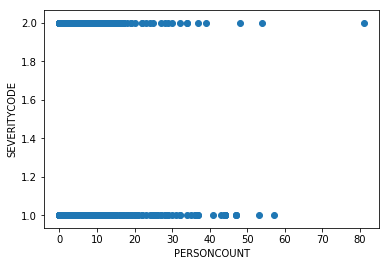

In [47]:
plt.scatter('PERSONCOUNT', 'SEVERITYCODE', data=df_ord)
plt.xlabel('PERSONCOUNT')
plt.ylabel('SEVERITYCODE')

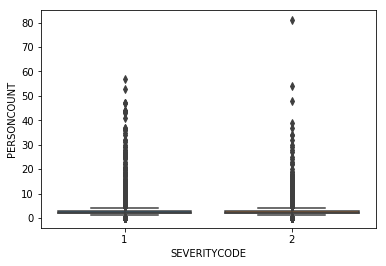

In [48]:
sns.boxplot('SEVERITYCODE', 'PERSONCOUNT', data=df)

In [49]:
NaN_df['PERSONCOUNT'].value_counts().head(10)

2    114231
3     35553
4     14660
1     13154
5      6584
0      5544
6      2702
7      1131
8       533
9       216
Name: PERSONCOUNT, dtype: int64

# Convert the categorical features to numeric

## Note: showing some attempts to break the result as explained in the project document

In [50]:
# 40 features
# features_df = NaN_df[['ADDRTYPE', 'WEATHER', 'LIGHTCOND', 'COLLISIONTYPE', 
#                       'UNDERINFL', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 
#                       'VEHCOUNT', 'SDOT_COLCODE']]
# 39 features
# features_df = NaN_df[['ADDRTYPE', 'WEATHER', 'LIGHTCOND', 'COLLISIONTYPE', 
#                       'UNDERINFL', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 
#                       'VEHCOUNT']]
# 35 features
features_df = NaN_df[['ADDRTYPE', 'WEATHER', 'LIGHTCOND', 'COLLISIONTYPE', 
                      'UNDERINFL']]
# 74 features
# features_df = NaN_df[['ADDRTYPE', 'WEATHER', 'LIGHTCOND', 'COLLISIONTYPE', 
#                       'UNDERINFL', 'SDOT_COLDESC']]

In [51]:
features_df.shape

(194673, 5)

In [52]:
features_df = pd.get_dummies(data=features_df, columns=['ADDRTYPE', 'WEATHER', 'LIGHTCOND', 
                                                        'COLLISIONTYPE','UNDERINFL'])

In [53]:
features_df.shape

(194673, 35)

In [54]:
features_df.head()

,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,WEATHER_Blowing Sand/Dirt,WEATHER_Clear,WEATHER_Fog/Smog/Smoke,WEATHER_Other,WEATHER_Overcast,WEATHER_Partly Cloudy,WEATHER_Raining,...,COLLISIONTYPE_Head On,COLLISIONTYPE_Left Turn,COLLISIONTYPE_Other,COLLISIONTYPE_Parked Car,COLLISIONTYPE_Pedestrian,COLLISIONTYPE_Rear Ended,COLLISIONTYPE_Right Turn,COLLISIONTYPE_Sideswipe,UNDERINFL_N,UNDERINFL_Y
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [55]:
features_df.dtypes

ADDRTYPE_Alley                        uint8
ADDRTYPE_Block                        uint8
ADDRTYPE_Intersection                 uint8
WEATHER_Blowing Sand/Dirt             uint8
WEATHER_Clear                         uint8
WEATHER_Fog/Smog/Smoke                uint8
WEATHER_Other                         uint8
WEATHER_Overcast                      uint8
WEATHER_Partly Cloudy                 uint8
WEATHER_Raining                       uint8
WEATHER_Severe Crosswind              uint8
WEATHER_Sleet/Hail/Freezing Rain      uint8
WEATHER_Snowing                       uint8
WEATHER_Unknown                       uint8
LIGHTCOND_Dark - No Street Lights     uint8
LIGHTCOND_Dark - Street Lights Off    uint8
LIGHTCOND_Dark - Street Lights On     uint8
LIGHTCOND_Dark - Unknown Lighting     uint8
LIGHTCOND_Dawn                        uint8
LIGHTCOND_Daylight                    uint8
LIGHTCOND_Dusk                        uint8
LIGHTCOND_Other                       uint8
LIGHTCOND_Unknown               

# Put features into X for training

In [56]:
X = features_df.values
X[0:5]

array([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=uint8)

# Scale the features in X

In [57]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.06223095, -1.39914699,  1.41129279, -0.01696304, -1.21707436,
        -0.05414257, -0.06551471,  2.45445634, -0.00506801, -0.45298634,
        -0.011333  , -0.02409974, -0.06841713, -0.28988624, -0.08920831,
        -0.07872239, -0.576075  , -0.00751719, -0.1141037 ,  0.77768637,
        -0.17682024, -0.03476509, -0.27267986,  2.14811072, -0.16915004,
        -0.10249953, -0.27517219, -0.37234172, -0.61077372, -0.18744809,
        -0.46074827, -0.12417149, -0.32510694,  0.2217116 , -0.2217116 ],
       [-0.06223095,  0.71472119, -0.70857019, -0.01696304, -1.21707436,
        -0.05414257, -0.06551471, -0.4074222 , -0.00506801,  2.2075721 ,
        -0.011333  , -0.02409974, -0.06841713, -0.28988624, -0.08920831,
        -0.07872239,  1.73588509, -0.00751719, -0.1141037 , -1.2858654 ,
        -0.17682024, -0.03476509, -0.27267986, -0.46552535, -0.16915004,
        -0.10249953, -0.27517219, -0.37234172, -0.61077372, -0.18744809,
        -0.46074827, -0.12417149,  3.07591099,  0.

# Our independent, target, y-axis variable is SEVERITYDESC

In [58]:
y = NaN_df['SEVERITYDESC']
y.value_counts()

Property Damage Only Collision    136485
Injury Collision                   58188
Name: SEVERITYDESC, dtype: int64

# Train the model

In [59]:
# Stratify to account for imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3, stratify=y)

In [60]:
print(X_train.shape, y_train.shape)

(136271, 35) (136271,)


In [61]:
print(X_test.shape, y_test.shape)

(58402, 35) (58402,)


# Did it stratify? Yes

In [62]:
y_train.value_counts()

Property Damage Only Collision    95539
Injury Collision                  40732
Name: SEVERITYDESC, dtype: int64

In [63]:
y_test.value_counts()

Property Damage Only Collision    40946
Injury Collision                  17456
Name: SEVERITYDESC, dtype: int64

# Decision Tree

In [64]:
acciTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
acciTree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [65]:
yhat = acciTree.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, acciTree.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7483543820768909
Test set Accuracy:  0.7507105921030102


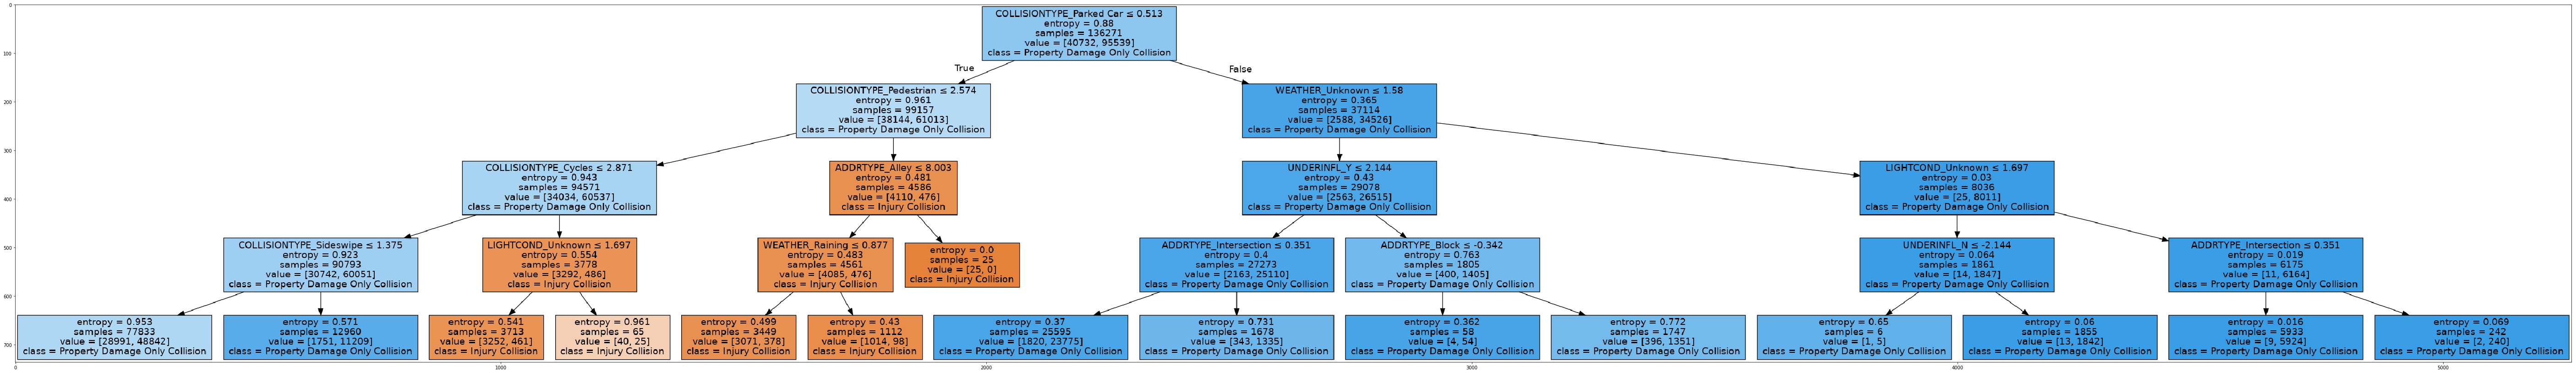

In [66]:
# Note: 35 features below
dot_data = StringIO()
filename = "accitree.png"
featureNames = features_df.columns[0:35]
targetNames = NaN_df["SEVERITYDESC"].unique().tolist()
out=tree.export_graphviz(acciTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# K-Nearest Neighbor

In [67]:
k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [68]:
yhat = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7390714091773011
Test set Accuracy:  0.7391356460395192


## Find the best k - loop 9 times

In [69]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    print("Evaluating: {} of 9".format(n)
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)    
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

Evaluating: 1 of 9
Evaluating: 2 of 9
Evaluating: 3 of 9
Evaluating: 4 of 9
Evaluating: 5 of 9
Evaluating: 6 of 9
Evaluating: 7 of 9
Evaluating: 8 of 9
Evaluating: 9 of 9


array([0.60787302, 0.59210301, 0.64400192, 0.62907092, 0.7256772 ,
       0.71738982, 0.73913565, 0.7232629 , 0.73655012])

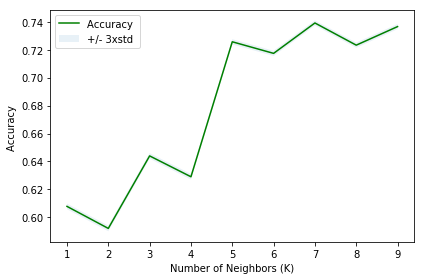

In [70]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [71]:
## Compare the accuracy below with the Decision Tree

In [72]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7391356460395192 with k= 7


# Logistic Regression

In [73]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [74]:
yhat = LR.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7488533877347344
Test set Accuracy:  0.7510530461285573
